# CH05: Compressing Data via Dimensionality Reduction

In [61]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), ".."))

## Unsupervised dimensionality reduction via principal component analysis

### Extracting the principal components step by step

In [16]:
# Load dataset

import pandas as pd
from sklearn import datasets

wine = datasets.load_wine()
df_wine = pd.DataFrame(wine.data, columns=wine.feature_names)
df_wine["target"] = wine.target

In [14]:
df_wine.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [21]:
# Split dataset into training and test subsets

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, :-1], df_wine.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [22]:
# Standardize the features

from sklearn.preprocessing import StandardScaler

sc = StandardScaler().fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [24]:
# Construct covariance matrix & obtain eigenvectors/eigenvalues

import numpy as np

cov_mat = np.cov(X_train_std.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

In [75]:
eigen_vals/np.sum(eigen_vals)

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.00820609,
       0.01629614, 0.01172226, 0.01380021])

### Total and explained variance

In [29]:
tot = sum(eigen_vals)
var_exp = [ i/tot for i in sorted(eigen_vals, reverse=True) ]
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([0.36951469, 0.55386396, 0.67201555, 0.74535807, 0.80957914,
       0.86009639, 0.89964293, 0.92608211, 0.9499753 , 0.96627144,
       0.98007165, 0.99179391, 1.        ])

In [30]:
import matplotlib.pyplot as plt

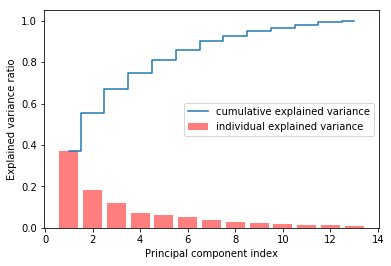

In [33]:
plt.bar(range(1, 14), var_exp, alpha=0.5, align="center", label="individual explained variance", color="red")
plt.step(range(1, 14), cum_var_exp, where="mid", label="cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

### Feature transformation

In [109]:
eigen_pairs = [ (np.abs(val), vec) for val, vec in zip(eigen_vals, eigen_vecs) ]
eigen_pairs.sort(key=lambda x: x[0], reverse=True)

In [110]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

In [111]:
W

array([[-0.13724218,  0.24724326],
       [ 0.50303478,  0.16487119],
       [-0.13774873,  0.09615039],
       [-0.0032961 ,  0.56264669],
       [-0.29062523,  0.08953787],
       [ 0.29909685,  0.6270364 ],
       [ 0.07905293, -0.27400201],
       [-0.36817641, -0.01257758],
       [-0.39837702,  0.11045823],
       [-0.09448698,  0.02636524],
       [ 0.37463888, -0.1374056 ],
       [-0.12783451,  0.08064016],
       [ 0.26283426, -0.26676921]])

In [112]:
X_train_pca = X_train_std.dot(W)

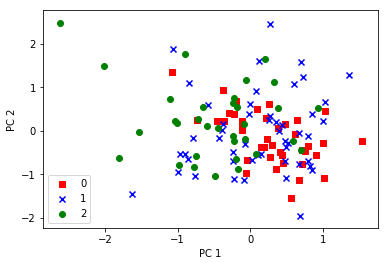

In [113]:
colors = ["r", "b", "g"]
markers = ["s", "x", "o"]

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

## Principal component analysis in scikit-learn

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [58]:
pca = PCA(n_components=2).fit(X_train_std)

X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [59]:
lr = LogisticRegression()
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

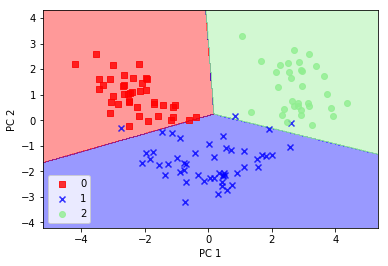

In [66]:
from utils import plot_decision_regions

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

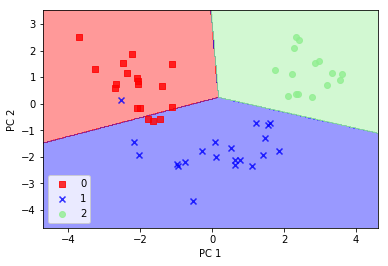

In [68]:
# Decision regions for test dataset

plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc="lower left")
plt.show()

In [69]:
# explained variance

pca = PCA(n_components=None).fit(X_train_std)
pca.explained_variance_ratio_ # compare with own implementation

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

In [106]:
pca.components_

array([[-1.37242175e-01,  2.47243265e-01, -2.54515927e-02,
         2.06945084e-01, -1.54365821e-01, -3.93769523e-01,
        -4.17351064e-01,  3.05728961e-01, -3.06683469e-01,
         7.55406578e-02, -3.26132628e-01, -3.68610222e-01,
        -2.96696514e-01],
       [ 5.03034778e-01,  1.64871190e-01,  2.44564761e-01,
        -1.13529045e-01,  2.89745182e-01,  5.08010391e-02,
        -2.28733792e-02,  9.04888470e-02,  8.35232677e-03,
         5.49775805e-01, -2.07164328e-01, -2.49025357e-01,
         3.80229423e-01],
       [-1.37748734e-01,  9.61503863e-02,  6.77775667e-01,
         6.25040550e-01,  1.96135481e-01,  1.40310572e-01,
         1.17053859e-01,  1.31217777e-01,  3.04309008e-02,
        -7.99299713e-02,  5.30591506e-02,  1.32391030e-01,
        -7.06502178e-02],
       [-3.29610003e-03,  5.62646692e-01, -1.08977111e-01,
         3.38187002e-02, -3.67511070e-01,  2.40245127e-01,
         1.87053299e-01, -2.29262234e-02,  4.96262330e-01,
         1.06482939e-01, -3.69053747e